<a href="https://colab.research.google.com/github/dliang5299/MIDS-207-Final-Project/blob/main/Model_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project: Model Testing

## Data Intake

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

import os

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2

# Read in data
DATA_PATH_PROC = "/content/drive/MyDrive/DATASCI 207/Final Project/NBA data - processed"

In [3]:
# Import data
odds_train = pd.read_csv(os.path.join(DATA_PATH_PROC, "odds_train.csv"))
odds_val = pd.read_csv(os.path.join(DATA_PATH_PROC, "odds_val.csv"))
odds_test = pd.read_csv(os.path.join(DATA_PATH_PROC, "odds_test.csv"))
X_train = pd.read_csv(os.path.join(DATA_PATH_PROC, "X_train.csv"))
X_val = pd.read_csv(os.path.join(DATA_PATH_PROC, "X_val.csv"))
X_test = pd.read_csv(os.path.join(DATA_PATH_PROC, "X_test.csv"))
y_train = pd.read_csv(os.path.join(DATA_PATH_PROC, "y_train.csv"))
y_val = pd.read_csv(os.path.join(DATA_PATH_PROC, "y_val.csv"))
y_test = pd.read_csv(os.path.join(DATA_PATH_PROC, "y_test.csv"))

In [4]:
# Check labels
print(y_train.columns)

Index(['spread', 'vegas_spread', 'covered_spread'], dtype='object')


In [5]:
# Drop 2012-13 data, as it does not have good previous seasons to calibrate
X_train = X_train[X_train['season'] != '2012-13']
y_train = y_train.loc[X_train.index]
odds_train = odds_train.loc[X_train.index]
print(X_train.shape)
print(y_train.shape)

(4917, 142)
(4917, 3)


In [6]:
# Drop non-numeric and ID features
X_train = X_train.drop(['season'], axis = 1)
X_val = X_val.drop(['season'], axis = 1)
X_test = X_test.drop(['season'], axis = 1)

In [7]:
# Separate actual and Vegas spreads
y_train, y_train_vegas, y_train_class = y_train['spread'], y_train['vegas_spread'], y_train['covered_spread']
y_val, y_val_vegas, y_val_class = y_val['spread'], y_val['vegas_spread'], y_val['covered_spread']
y_test, y_test_vegas, y_test_class = y_test['spread'], y_test['vegas_spread'], y_test['covered_spread']

In [8]:
# Examine data
X_train.head()

,days_since_last_game_away,days_since_last_game_home,consecutive_away_games,pts_tot_last50_away,pts_tot_last50_home,fg_pct_last50_away,fg_pct_last50_home,ft_pct_last50_away,ft_pct_last50_home,fg3_pct_last50_away,fg3_pct_last50_home,ast_last50_away,ast_last50_home,reb_last50_away,reb_last50_home,tov_last50_away,tov_last50_home,spread_last50_away,spread_last50_home,wr_last50_away,wr_last50_home,pts_tot_last10_away,pts_tot_last10_home,fg_pct_last10_away,fg_pct_last10_home,ft_pct_last10_away,ft_pct_last10_home,fg3_pct_last10_away,fg3_pct_last10_home,ast_last10_away,ast_last10_home,reb_last10_away,reb_last10_home,tov_last10_away,tov_last10_home,spread_last10_away,spread_last10_home,wr_last10_away,wr_last10_home,pts_tot_last20_away,pts_tot_last20_home,fg_pct_last20_away,fg_pct_last20_home,ft_pct_last20_away,ft_pct_last20_home,fg3_pct_last20_away,fg3_pct_last20_home,ast_last20_away,ast_last20_home,reb_last20_away,reb_last20_home,tov_last20_away,tov_last20_home,spread_last20_away,spread_last20_home,wr_last20_away,wr_last20_home,pts_tot_last10_loc_away,pts_tot_last10_loc_home,fg_pct_last10_loc_away,fg_pct_last10_loc_home,ft_pct_last10_loc_away,ft_pct_last10_loc_home,fg3_pct_last10_loc_away,fg3_pct_last10_loc_home,ast_last10_loc_away,ast_last10_loc_home,reb_last10_loc_away,reb_last10_loc_home,tov_last10_loc_away,tov_last10_loc_home,spread_last10_loc_away,spread_last10_loc_home,wr_last10_loc_away,wr_last10_loc_home,pts_tot_last20_loc_away,pts_tot_last20_loc_home,fg_pct_last20_loc_away,fg_pct_last20_loc_home,ft_pct_last20_loc_away,ft_pct_last20_loc_home,fg3_pct_last20_loc_away,fg3_pct_last20_loc_home,ast_last20_loc_away,ast_last20_loc_home,reb_last20_loc_away,reb_last20_loc_home,tov_last20_loc_away,tov_last20_loc_home,spread_last20_loc_away,spread_last20_loc_home,wr_last20_loc_away,wr_last20_loc_home,pts_tot_last50_loc_away,pts_tot_last50_loc_home,fg_pct_last50_loc_away,fg_pct_last50_loc_home,ft_pct_last50_loc_away,ft_pct_last50_loc_home,fg3_pct_last50_loc_away,fg3_pct_last50_loc_home,ast_last50_loc_away,ast_last50_loc_home,reb_last50_loc_away,reb_last50_loc_home,tov_last50_loc_away,tov_last50_loc_home,spread_last50_loc_away,spread_last50_loc_home,wr_last50_loc_away,wr_last50_loc_home,team_abbr_home_ATL,team_abbr_home_BKN,team_abbr_home_BOS,team_abbr_home_CHA,team_abbr_home_CHI,team_abbr_home_CLE,team_abbr_home_DAL,team_abbr_home_DEN,team_abbr_home_DET,team_abbr_home_GSW,team_abbr_home_HOU,team_abbr_home_IND,team_abbr_home_LAC,team_abbr_home_LAL,team_abbr_home_MEM,team_abbr_home_MIA,team_abbr_home_MIL,team_abbr_home_MIN,team_abbr_home_NOP,team_abbr_home_NYK,team_abbr_home_OKC,team_abbr_home_ORL,team_abbr_home_PHI,team_abbr_home_PHX,team_abbr_home_POR,team_abbr_home_SAC,team_abbr_home_SAS,team_abbr_home_TOR,team_abbr_home_UTA,team_abbr_home_WAS
1187,3.444724,3.014895,-1.502148,-1.297061,-0.804159,-0.569034,-0.656483,-0.125630,-0.015211,-1.807693,-0.297349,0.614268,-0.897575,-0.104259,1.640293,-0.500368,0.346769,2.074874,-1.186349,-2.185387,0.767726,-1.567411,-0.689130,-1.263968,-0.178655,-1.240278,-0.692122,-1.295693,-1.701479,-0.494278,-1.127795,1.367726,-0.081138,-0.174011,0.289596,1.394564,0.297100,-1.395332,0.003895,-1.452281,-0.552614,-1.153942,-0.572884,-1.033084,0.110651,-1.556177,-0.847687,-0.708154,-0.856917,0.358053,1.303860,-0.363732,0.122547,1.880324,-0.662982,-1.939624,0.276467,-1.334685,-1.144433,-0.693828,-1.184832,-0.856553,-0.196131,-2.191266,-1.877645,-0.464368,-1.982204,1.034923,1.282190,-0.895257,0.159469,1.230613,0.008864,-2.044296,-0.379797,-1.368669,-0.294401,-0.482798,-0.454448,-0.647803,-0.470356,-2.962086,-0.336369,0.474603,-1.030229,0.929656,1.204107,-0.862059,0.140169,1.127141,-0.807570,-1.818237,0.106082,-1.207329,-0.700922,-0.266241,-1.096674,0.538637,-0.344916,-3.100866,0.660305,1.019283,-1.225833,0.724141,2.073265,-0.720863,-0.086937,0.961521,-1.054521,-1.444487,0.889032,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,Fa

## Baseline linear regression

In [9]:
# Now train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr_train = lr_model.predict(X_train)
y_pred_lr_val = lr_model.predict(X_val)

# Evaluate the model
mse_lr_train = mean_squared_error(y_train, y_pred_lr_train)
mse_lr_val = mean_squared_error(y_val, y_pred_lr_val)

# Print results
print(f'Linear Regression Train Mean Squared Error: {mse_lr_train}')
print(f'Linear Regression Val Mean Squared Error: {mse_lr_val}')

Linear Regression Train Mean Squared Error: 0.7875196859625294
Linear Regression Val Mean Squared Error: 0.9208792536916501


## Random Forest

In [10]:
# Create a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, n_jobs=5, max_depth=4, random_state=1234)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_val = rf_model.predict(X_val)

# Evaluate the model
mse_rf_train = mean_squared_error(y_train, y_pred_rf_train)
mse_rf_val = mean_squared_error(y_val, y_pred_rf_val)

# Print results
print(f'Random Forest Train Mean Squared Error: {mse_rf_train}')
print(f'Random Forest Val Mean Squared Error: {mse_rf_val}')

Random Forest Train Mean Squared Error: 0.7796288177402066
Random Forest Val Mean Squared Error: 0.8710501849952723


## Neural Network

### Regression

In [11]:
# # Set seed
# tf.random.set_seed(1234)

# # Hyperparameters space
# space = {
#     'units1': hp.quniform('units1', 10, 300, 10),
#     'units2': hp.quniform('units2', 10, 200, 10),
#     'activation': hp.choice('activation', ['relu', 'tanh']),
#     'dropout': hp.quniform('dropout', 0, 0.5, 0.1),
#     'lr': hp.loguniform('lr', np.log(0.001), np.log(0.1))
# }
# trials = Trials()

# # Define the function to create the Keras model
# def create_model(params):
#     tf.keras.backend.clear_session()
#     tf.random.set_seed(1234)
#     model = Sequential()
#     model.add(Dense(int(params['units1']), activation=params['activation']))
#     model.add(Dropout(params['dropout']))
#     model.add(Dense(int(params['units2']), activation=params['activation']))
#     model.add(Dropout(params['dropout']))
#     model.add(Dense(1))  # Output layer for classification
#     optimizer = tf.keras.optimizers.Adam(learning_rate=params['lr'])
#     model.compile(optimizer=optimizer, loss='mean_squared_error')
#     return model

# # Define the objective function
# def objective(params):
#     model = create_model(params)
#     model_fit = model.fit(X_train, y_train, epochs=15, batch_size=32, verbose=0,
#               validation_data=(X_val, y_val))
#     loss = model_fit.history['val_loss'][-1]
#     return {'loss': loss, 'status': STATUS_OK}

# # Hyperparameter optimization
# best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)
# print("Best parameters:", best)

In [12]:
# # Create the model with the best hyperparameters
# best_params = {'units1': int(best['units1']),
#                'units2': int(best['units2']),
#                'activation': ['relu', 'tanh'][int(best['activation'])],
#                'dropout': best['dropout'],
#                'lr': best['lr']}
# best_model = create_model(best_params)
# best_model_fit = best_model.fit(X_train, y_train, epochs=15, batch_size=32,
#                                 verbose=0, validation_data=(X_val, y_val))

In [13]:
# # Plot training performance
# fig, ax = plt.subplots()
# ax.plot(best_model_fit.history['loss'])
# ax.plot(best_model_fit.history['val_loss'])
# ax.set_title('MSE over epochs')
# ax.set_xlabel('Epochs')
# ax.set_ylabel('MSE')
# ax.legend(['Train', 'Validation'], fontsize=10)
# plt.show()

In [14]:
# # Print results
# print("Training MSE:", best_model.evaluate(x = X_train, y = y_train))
# print("Validation MSE:", best_model.evaluate(x = X_val, y = y_val))

### Classifier

In [15]:
# Baseline
print("Baseline accuracy - train:", 100 * np.count_nonzero(y_train_class == 1) / (np.count_nonzero(y_train_class == 0) + np.count_nonzero(y_train_class == 1)), "%")
print("Baseline accuracy - val:", 100 * np.count_nonzero(y_val_class == 1) / (np.count_nonzero(y_val_class == 0) + np.count_nonzero(y_val_class == 1)), "%")

Baseline accuracy - train: 49.928818385194226 %
Baseline accuracy - val: 49.02439024390244 %


In [16]:
# Inspect data
X_train.head()

,days_since_last_game_away,days_since_last_game_home,consecutive_away_games,pts_tot_last50_away,pts_tot_last50_home,fg_pct_last50_away,fg_pct_last50_home,ft_pct_last50_away,ft_pct_last50_home,fg3_pct_last50_away,fg3_pct_last50_home,ast_last50_away,ast_last50_home,reb_last50_away,reb_last50_home,tov_last50_away,tov_last50_home,spread_last50_away,spread_last50_home,wr_last50_away,wr_last50_home,pts_tot_last10_away,pts_tot_last10_home,fg_pct_last10_away,fg_pct_last10_home,ft_pct_last10_away,ft_pct_last10_home,fg3_pct_last10_away,fg3_pct_last10_home,ast_last10_away,ast_last10_home,reb_last10_away,reb_last10_home,tov_last10_away,tov_last10_home,spread_last10_away,spread_last10_home,wr_last10_away,wr_last10_home,pts_tot_last20_away,pts_tot_last20_home,fg_pct_last20_away,fg_pct_last20_home,ft_pct_last20_away,ft_pct_last20_home,fg3_pct_last20_away,fg3_pct_last20_home,ast_last20_away,ast_last20_home,reb_last20_away,reb_last20_home,tov_last20_away,tov_last20_home,spread_last20_away,spread_last20_home,wr_last20_away,wr_last20_home,pts_tot_last10_loc_away,pts_tot_last10_loc_home,fg_pct_last10_loc_away,fg_pct_last10_loc_home,ft_pct_last10_loc_away,ft_pct_last10_loc_home,fg3_pct_last10_loc_away,fg3_pct_last10_loc_home,ast_last10_loc_away,ast_last10_loc_home,reb_last10_loc_away,reb_last10_loc_home,tov_last10_loc_away,tov_last10_loc_home,spread_last10_loc_away,spread_last10_loc_home,wr_last10_loc_away,wr_last10_loc_home,pts_tot_last20_loc_away,pts_tot_last20_loc_home,fg_pct_last20_loc_away,fg_pct_last20_loc_home,ft_pct_last20_loc_away,ft_pct_last20_loc_home,fg3_pct_last20_loc_away,fg3_pct_last20_loc_home,ast_last20_loc_away,ast_last20_loc_home,reb_last20_loc_away,reb_last20_loc_home,tov_last20_loc_away,tov_last20_loc_home,spread_last20_loc_away,spread_last20_loc_home,wr_last20_loc_away,wr_last20_loc_home,pts_tot_last50_loc_away,pts_tot_last50_loc_home,fg_pct_last50_loc_away,fg_pct_last50_loc_home,ft_pct_last50_loc_away,ft_pct_last50_loc_home,fg3_pct_last50_loc_away,fg3_pct_last50_loc_home,ast_last50_loc_away,ast_last50_loc_home,reb_last50_loc_away,reb_last50_loc_home,tov_last50_loc_away,tov_last50_loc_home,spread_last50_loc_away,spread_last50_loc_home,wr_last50_loc_away,wr_last50_loc_home,team_abbr_home_ATL,team_abbr_home_BKN,team_abbr_home_BOS,team_abbr_home_CHA,team_abbr_home_CHI,team_abbr_home_CLE,team_abbr_home_DAL,team_abbr_home_DEN,team_abbr_home_DET,team_abbr_home_GSW,team_abbr_home_HOU,team_abbr_home_IND,team_abbr_home_LAC,team_abbr_home_LAL,team_abbr_home_MEM,team_abbr_home_MIA,team_abbr_home_MIL,team_abbr_home_MIN,team_abbr_home_NOP,team_abbr_home_NYK,team_abbr_home_OKC,team_abbr_home_ORL,team_abbr_home_PHI,team_abbr_home_PHX,team_abbr_home_POR,team_abbr_home_SAC,team_abbr_home_SAS,team_abbr_home_TOR,team_abbr_home_UTA,team_abbr_home_WAS
1187,3.444724,3.014895,-1.502148,-1.297061,-0.804159,-0.569034,-0.656483,-0.125630,-0.015211,-1.807693,-0.297349,0.614268,-0.897575,-0.104259,1.640293,-0.500368,0.346769,2.074874,-1.186349,-2.185387,0.767726,-1.567411,-0.689130,-1.263968,-0.178655,-1.240278,-0.692122,-1.295693,-1.701479,-0.494278,-1.127795,1.367726,-0.081138,-0.174011,0.289596,1.394564,0.297100,-1.395332,0.003895,-1.452281,-0.552614,-1.153942,-0.572884,-1.033084,0.110651,-1.556177,-0.847687,-0.708154,-0.856917,0.358053,1.303860,-0.363732,0.122547,1.880324,-0.662982,-1.939624,0.276467,-1.334685,-1.144433,-0.693828,-1.184832,-0.856553,-0.196131,-2.191266,-1.877645,-0.464368,-1.982204,1.034923,1.282190,-0.895257,0.159469,1.230613,0.008864,-2.044296,-0.379797,-1.368669,-0.294401,-0.482798,-0.454448,-0.647803,-0.470356,-2.962086,-0.336369,0.474603,-1.030229,0.929656,1.204107,-0.862059,0.140169,1.127141,-0.807570,-1.818237,0.106082,-1.207329,-0.700922,-0.266241,-1.096674,0.538637,-0.344916,-3.100866,0.660305,1.019283,-1.225833,0.724141,2.073265,-0.720863,-0.086937,0.961521,-1.054521,-1.444487,0.889032,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,Fa

In [17]:
# Selecting features
X_train_subset = X_train.drop(X_train.filter(regex='last10|last20').columns, axis=1)
X_val_subset = X_val.drop(X_val.filter(regex='last10|last20').columns, axis=1)
X_test_subset = X_test.drop(X_test.filter(regex='last10|last20').columns, axis=1)

# Inspect
X_train_subset.head()

,days_since_last_game_away,days_since_last_game_home,consecutive_away_games,pts_tot_last50_away,pts_tot_last50_home,fg_pct_last50_away,fg_pct_last50_home,ft_pct_last50_away,ft_pct_last50_home,fg3_pct_last50_away,fg3_pct_last50_home,ast_last50_away,ast_last50_home,reb_last50_away,reb_last50_home,tov_last50_away,tov_last50_home,spread_last50_away,spread_last50_home,wr_last50_away,wr_last50_home,pts_tot_last50_loc_away,pts_tot_last50_loc_home,fg_pct_last50_loc_away,fg_pct_last50_loc_home,ft_pct_last50_loc_away,ft_pct_last50_loc_home,fg3_pct_last50_loc_away,fg3_pct_last50_loc_home,ast_last50_loc_away,ast_last50_loc_home,reb_last50_loc_away,reb_last50_loc_home,tov_last50_loc_away,tov_last50_loc_home,spread_last50_loc_away,spread_last50_loc_home,wr_last50_loc_away,wr_last50_loc_home,team_abbr_home_ATL,team_abbr_home_BKN,team_abbr_home_BOS,team_abbr_home_CHA,team_abbr_home_CHI,team_abbr_home_CLE,team_abbr_home_DAL,team_abbr_home_DEN,team_abbr_home_DET,team_abbr_home_GSW,team_abbr_home_HOU,team_abbr_home_IND,team_abbr_home_LAC,team_abbr_home_LAL,team_abbr_home_MEM,team_abbr_home_MIA,team_abbr_home_MIL,team_abbr_home_MIN,team_abbr_home_NOP,team_abbr_home_NYK,team_abbr_home_OKC,team_abbr_home_ORL,team_abbr_home_PHI,team_abbr_home_PHX,team_abbr_home_POR,team_abbr_home_SAC,team_abbr_home_SAS,team_abbr_home_TOR,team_abbr_home_UTA,team_abbr_home_WAS
1187,3.444724,3.014895,-1.502148,-1.297061,-0.804159,-0.569034,-0.656483,-0.125630,-0.015211,-1.807693,-0.297349,0.614268,-0.897575,-0.104259,1.640293,-0.500368,0.346769,2.074874,-1.186349,-2.185387,0.767726,-1.207329,-0.700922,-0.266241,-1.096674,0.538637,-0.344916,-3.100866,0.660305,1.019283,-1.225833,0.724141,2.073265,-0.720863,-0.086937,0.961521,-1.054521,-1.444487,0.889032,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1188,3.444724,3.014895,-1.502148,-1.666579,0.682976,-1.099932,2.628650,0.205475,-0.251545,-0.703730,1.589095,0.601978,0.962409,0.200232,-2.040282,-0.883777,-0.871763,0.145703,-2.022852,0.121711,2.296962,-1.118376,1.382153,-0.248593,2.486374,0.829136,0.995901,-0.881329,2.210805,1.019283,0.361684,0.231692,-2.244596,-0.720863,-1.708397,-0.344681,-1.710386,0.772522,2.013821,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1189,3.444724,3.014895,-1.502148,0.176211,0.446171,1.287972,0.498374,-1.202887,-2.034059,0.314165,-0.056832,1.327062,0.494333,-0.560994,0.731977,-0.278394,0.346769,-0.980004,-0.090827,0.762572,0.640290,0.076140,0.479487,1.007633,0.401438,-1.988548,-2.877832,-0.353854,-0.369341,0.064322,0.890857,-0.070131,1.814931,-0.346130,0.738016,-1.163921,-0.515020,1.284139,0.728348,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1190,3.444724,3.014895,-1.502148,-0.414058,-0.415799,0.041271,-0.513851,-0.904426,0.287215,0.309774,-0.694920,-0.934216,-0.281687,0.552299,-1.027887,0.105015,-1.391137,-0.580421,0.877308,0.890744,-1.016382,-0.413103,-0.810862,0.011316,-1.294395,-0.322254,0.032779,0.053020,-0.784928,-0.275580,-0.167488,0.342890,-0.633087,-0.319363,-0.883444,-0.894660,1.272741,1.113600,-1.681914,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1191,-1.056748,3.014895,-0.715917,0.814468,-1.647184,2.685548,-0.444836,-0.222896,-0.991922,1.640327,0.164839,1.105850,0.876185,-2.035870,-0.744038,-0.803059,-1.151426,-2.127195,0.834846,2.428810,-0.761510,0.419246,-1.401066,2.411461,-0.374234,-0.731892,-1.759698,1.291916,-0.021740,0.873611,1.012973,-2.071698,-0.928325,-0.131996,-1.879077,-1.851395,0.881338,2.136835,-0.235757,False,False,False,False,False,False,False

In [18]:
# Hyperparameters space
space = {
    'units1': hp.quniform('units1', 10, 300, 10),
    'units2': hp.quniform('units2', 10, 200, 10),
    'activation': hp.choice('activation', ['relu', 'tanh']),
    'dropout': hp.quniform('dropout', 0, 0.5, 0.1),
    'lr': hp.loguniform('lr', np.log(0.001), np.log(0.1))
}
trials = Trials()

# Define the function to create the Keras model
def create_model(params):
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)
    model = Sequential()
    model.add(Dense(int(params['units1']), activation=params['activation']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(int(params['units2']), activation=params['activation']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for classification
    optimizer = tf.keras.optimizers.Adam(learning_rate=params['lr'])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the objective function
def objective(params):
    model = create_model(params)
    model_fit = model.fit(X_train_subset, y_train_class, epochs=15, batch_size=32, verbose=0,
              validation_data=(X_val_subset, y_val_class))
    loss = model_fit.history['val_loss'][-1]
    return {'loss': loss, 'status': STATUS_OK}

# Hyperparameter optimization
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)
print("Best parameters:", best)

100%|██████████| 50/50 [09:06<00:00, 10.93s/trial, best loss: 0.6929607391357422]
Best parameters: {'activation': 0, 'dropout': 0.0, 'lr': 0.04239309708290973, 'units1': 20.0, 'units2': 90.0}


Parameters


*   {'activation': 1, 'dropout': 0.5, 'lr': 0.007506522445580105, 'units1': 230.0, 'units2': 20.0}
*   {}



In [24]:
# Create the model with the best hyperparameters
best = {'activation': 1, 'dropout': 0.5, 'lr': 0.007506522445580105, 'units1': 230.0, 'units2': 20.0}
best_params = {'units1': int(best['units1']),
               'units2': int(best['units2']),
               'activation': ['relu', 'tanh'][int(best['activation'])],
               'dropout': best['dropout'],
               'lr': best['lr']}
best_model = create_model(best_params)
best_model_fit = best_model.fit(X_train_subset, y_train_class, epochs=15, batch_size=32,
                                verbose=0, validation_data=(X_val_subset, y_val_class))

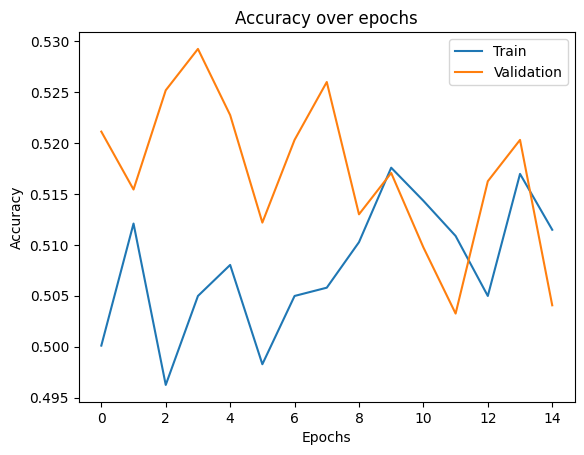

In [25]:
# Plot training performance
fig, ax = plt.subplots()
ax.plot(best_model_fit.history['accuracy'])
ax.plot(best_model_fit.history['val_accuracy'])
ax.set_title('Accuracy over epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend(['Train', 'Validation'], fontsize=10)
plt.show()

In [26]:
# Print results
print("Training accuracy:", best_model.evaluate(x = X_train_subset, y = y_train_class)[1])
print("Validation accuracy:", best_model.evaluate(x = X_val_subset, y = y_val_class)[1])

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5213 - loss: 0.6918
Training accuracy: 0.5192190408706665
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4842 - loss: 0.6970
Validation accuracy: 0.5040650367736816


## Calculating returns

In [27]:
# Column bind probabilities and odds
y_pred_train = best_model.predict(X_train_subset)
returns_train_df = pd.concat([odds_train, pd.DataFrame(y_pred_train, columns = ['prob']), pd.DataFrame(y_train_class, columns = ['covered_spread'])], axis = 1)
returns_train_df['covered_spread_bet'] = returns_train_df.apply(lambda row: 1 if row['prob'] > 0.5 else 0, axis=1)

# Calculate adjusted win prob. based on bet
returns_train_df['adj_win_prob'] = returns_train_df.apply(lambda row: row['prob'] if row['prob'] > 0.5 else 1 - row['prob'], axis=1)
returns_train_df['kelly_wager'] = 100 * (returns_train_df['adj_win_prob'] - (1 - returns_train_df['adj_win_prob']) / returns_train_df['spread_odds'])
returns_train_df.loc[returns_train_df['kelly_wager'] < 0, 'kelly_wager'] = 0
returns_train_df['return'] = returns_train_df.apply(lambda row: -row['kelly_wager'] if row['covered_spread_bet'] != row['covered_spread'] else row['kelly_wager'] * (1 + row['spread_odds']), axis=1)

# Calculate returns
print("Total training return:", returns_train_df['return'].sum())
print("Over number of games:", returns_train_df.shape[0])
print("Percent training return:", returns_train_df['return'].sum() / returns_train_df['kelly_wager'].sum())
print("Average training return:", returns_train_df['return'].mean())

154/154 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Total training return: 8084.630201842606
Over number of games: 6104
Percent training return: 0.4217740660382782
Average training return: 2.167461180118661


In [28]:
# Column bind probabilities and odds
y_pred_val = best_model.predict(X_val_subset)
returns_val_df = pd.concat([odds_val, pd.DataFrame(y_pred_val, columns = ['prob']), pd.DataFrame(y_val_class, columns = ['covered_spread'])], axis = 1)
returns_val_df['covered_spread_bet'] = returns_val_df.apply(lambda row: 1 if row['prob'] > 0.5 else 0, axis=1)

# Calculate adjusted win prob. based on bet
returns_val_df['adj_win_prob'] = returns_val_df.apply(lambda row: row['prob'] if row['prob'] > 0.5 else 1 - row['prob'], axis=1)
returns_val_df['kelly_wager'] = 100 * (returns_val_df['adj_win_prob'] - (1 - returns_val_df['adj_win_prob']) / returns_val_df['spread_odds'])
returns_val_df.loc[returns_val_df['kelly_wager'] < 0, 'kelly_wager'] = 0
returns_val_df['return'] = returns_val_df.apply(lambda row: -row['kelly_wager'] if row['covered_spread_bet'] != row['covered_spread'] else row['kelly_wager'] * (1 + row['spread_odds']), axis=1)

# Calculate returns
print("Total validation return:", returns_val_df['return'].sum())
print("Over number of games:", returns_val_df.shape[0])
print("Percent validation return:", returns_val_df['return'].sum() / returns_val_df['kelly_wager'].sum())
print("Average validation return:", returns_val_df['return'].mean())

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Total validation return: 3618.6680534855764
Over number of games: 1230
Percent validation return: 0.5511430212438928
Average validation return: 2.942006547549249
